<a href="https://colab.research.google.com/github/mdotdotdot/DIP_Assignments/blob/main/DIP_PLIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 #uwu
from google.colab.patches import cv2_imshow
secret_image = cv2.imread("wth.png")

In [52]:
def circular_shift_nibble(value, key):
    shift = (key%3) + 1
    shifted_value = (value >> shift) | (value << (4 - shift))
    shifted_value &= 0b1111
    return shifted_value

660


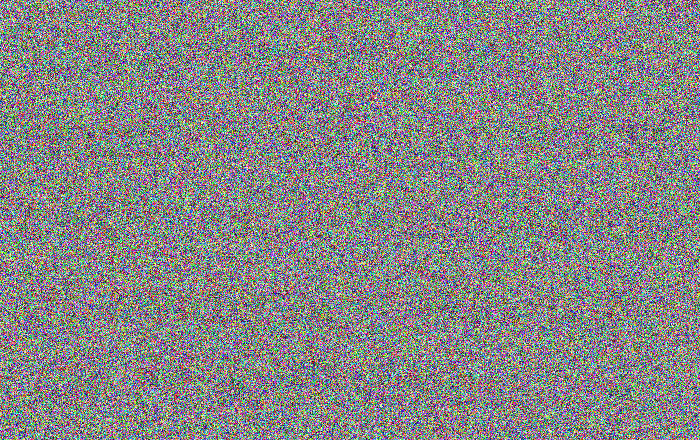

In [53]:
base_image = np.zeros(secret_image.shape, dtype=np.uint8)
image_size=base_image.shape
base_image = np.random.randint(0, 256, size=(image_size[0],image_size[1] , 3), dtype=np.uint8)
msg = 'isshit'
temp_key = [ord(char) for char in msg]
key = sum(temp_key)
print(key)
def map_rgb_channels(number, image1):
    # Map RGB channels based on the provided number
    if number == 0:
        mapped_array = image1
    elif number == 1:
        mapped_array = image1[:, :, (1, 2, 0)]  # Map BGR to GRB
    elif number == 2:
        mapped_array = image1[:, :, (2, 0, 1)]  # Map BGR to RBG
    elif number == 3:
        mapped_array = image1[:, :, (1, 0, 2)]  # Map BGR to GBR
    elif number == 4:
        mapped_array = image1[:, :, ::-1]  # Reverse BGR order
    elif number == 5:
        mapped_array = image1[:, :, (2, 1, 0)]  # Map BGR to RGB
    return mapped_array

number = key%6
mapped_secret_image = map_rgb_channels(number,secret_image)
def bit_slice_and_embed(base_image, secret_image):
    msb_sliced = (secret_image >> 4)
    msb_sliced = circular_shift_nibble(msb_sliced,key)
    lsb_cleared =  base_image & 0xF0F0F0
    result_array = lsb_cleared | msb_sliced
    return result_array
embedded_image = bit_slice_and_embed(base_image, mapped_secret_image)
cv2_imshow(embedded_image)

In [54]:
index_of_hidden_message = [random.randint(0,embedded_image.shape[0] if embedded_image.shape[0]<510 else 510),random.randint(0,embedded_image.shape[1] if embedded_image.shape[1]<256 else 256 ),0]
print(index_of_hidden_message)
print(embedded_image.shape)
if index_of_hidden_message[0]>255:
  index_of_hidden_message[2] = index_of_hidden_message[0]-255
  index_of_hidden_message[0] = 255
embedded_image[0][0][0] = index_of_hidden_message[0]
embedded_image[0][0][1] = index_of_hidden_message[1]
embedded_image[0][0][2] = index_of_hidden_message[2]
# In first pixel of embedded image, we have the index of hidden message stored

def remaining_space(embedded_image,index_of_hidden_message):
  height_left = embedded_image.shape[0] - (index_of_hidden_message[0] + index_of_hidden_message[2])
  width_of_first_row = embedded_image.shape[1] - index_of_hidden_message[1] - 1
  total_space_left = ((height_left) * embedded_image.shape[1]) - (embedded_image.shape[1]-width_of_first_row)
  return total_space_left
# makes sure length of prompt can fit the image
slice_length = min(len(msg),remaining_space(embedded_image,index_of_hidden_message))
msg = msg[:slice_length]
embedded_image[0][1][0] = len(msg)
ascii_message = temp_key
def array_of_integers_to_bits(input_array, num_bits=8):
    # Convert each integer to binary and format it with zero-padding
    bits_array = [format(integer, f'0{num_bits}b') for integer in input_array]
    return bits_array
bitted_ascii = array_of_integers_to_bits(ascii_message,8)
print(embedded_image.shape)
row, col = index_of_hidden_message[0] + index_of_hidden_message[2], index_of_hidden_message[1]
# bit_shifting_algo = key%3
for i in temp_key:
  if col >= embedded_image.shape[1]:
    col = 0
    row += 1
  itt = bin(i)[2:].zfill(8)  # Convert to binary and ensure it has 8 bits
  embedded_image[row, col, 0] = (embedded_image[row, col, 0] & 0x0F) | ((int(itt[0:4], 2)<<4) & 0xF0)
  embedded_image[row, col, 1] = (embedded_image[row, col, 1] & 0x0F) | ((int(itt[4:], 2)<<4) & 0xF0)
  col += 1
final_image = np.array(embedded_image, dtype=np.uint8)
cv2.imwrite('bakra.png',final_image)

[195, 113, 0]
(440, 700, 3)
(440, 700, 3)


True

## <font color="red">DECRYPTION</font>

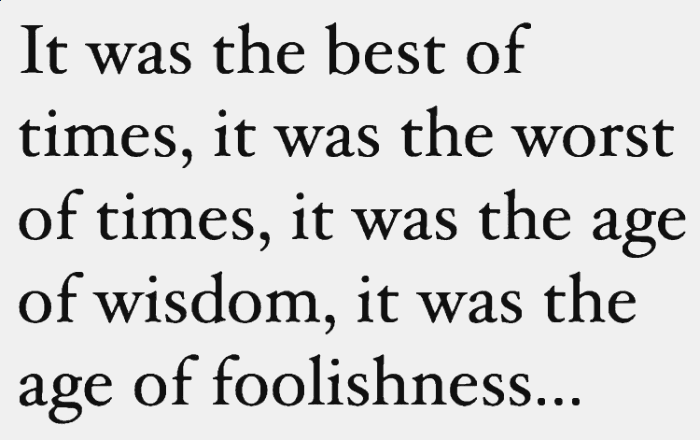

In [55]:
image =embedded_image
# extracting index
index = [image[0][0][0]+image[0][0][2],image[0][0][1]]
length = image[0][1][0]
string = []
for i in range(length):
  ascii_code = (image[index[0]][index[1]+i][0]>>4)<<4
  ascii_code = ascii_code | (image[index[0]][index[1]+i][1]>>4)
  string.append(ascii_code)
def extract_embedded_image(image):
  extracted_bits = (image & 0x0F) << 4
  return extracted_bits
extracted_image = extract_embedded_image(image)
key = sum(string)%6
def reverse_circular_shift_nibble(value, key):
    # Perform reverse circular shift
    shift = (key%3) + 1
    restored_value = (value << shift) | (value >> (4 - shift))
    restored_value &= 0b1111
    return restored_value
def reverse_map_rgb_channels(number, mapped_image):
  # Reverse map RGB channels based on the provided number
  if number == 0:
      original_array = mapped_image
  elif number == 1:
      original_array = mapped_image[:, :, (2, 0, 1)]  # Reverse map GBR to RGB
  elif number == 2:
      original_array = mapped_image[:, :, (1, 2, 0)]  # Reverse map BRG to RGB
  elif number == 3:
      original_array = mapped_image[:, :, (1, 0, 2)]  # Reverse map GBR to RGB
  elif number == 4:
      original_array = mapped_image[:, :, ::-1]  # Reverse RGB order
  elif number == 5:
      # original_array = mapped_image[:, :, ::-2]  # Reverse and swap RG channels
      original_array = mapped_image[:, :, ::-1]  # Reverse RGB order

  return original_array
extracted_image = reverse_circular_shift_nibble(extracted_image>>4,key) << 4
reverse_mapped_secret_image = reverse_map_rgb_channels(key, extracted_image)
cv2_imshow(reverse_mapped_secret_image)

### Arslna working on the length of msg check


In [ ]:
embed_image = [
    [1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 7, 8]
]

embed_image = np.array(embed_image)
index_of_hidden_message = [4, 5, 0]
height_left = embed_image.shape[0] - (index_of_hidden_message[0] + index_of_hidden_message[2])
width_of_first_row = embed_image.shape[1] - index_of_hidden_message[1] - 1
total_space_left = ((height_left) * embed_image.shape[1]) - (embed_image.shape[1]-width_of_first_row)

print(total_space_left)

In [18]:
import cv2
image= cv2.imread('slay.jpg')
def circular_shift_nibble(value, key):
    # Ensure shift is within the range [0, 4)
    shift = (key%3) + 1

    # Perform circular shift
    shifted_value = (value >> shift) | (value << (4 - shift))

    # Mask to keep only the lower 4 bits (nibble)
    shifted_value &= 0b1111

    return shifted_value

def bit_slice_and_embed(secret_image):
    secret_image = (secret_image >> 4)
    print(secret_image[100][300][2])
    secret_image = circular_shift_nibble(secret_image, 1)
    result_array = (secret_image)
    return result_array
print(bit_slice_and_embed(image)[100][300][2])


11
14
